In [1]:
! pip install lightgbm

In [2]:
! pip install catboost

In [3]:
! pip install optuna

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import warnings #игнорирует ошибки
warnings.filterwarnings("ignore")

from sklearn.linear_model import SGDRegressor, HuberRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline 
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.ensemble import VotingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.dummy import DummyRegressor

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

from catboost import CatBoostRegressor

from lightgbm import plot_importance
from lightgbm import LGBMRegressor

import time
import joblib 


# Описание проекта

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля. 

Цель проекта: построить модель, которая умеет определять цену автомобиля используя данные о технических характеристиках, комплектации и ценах других автомобилей.

Критерии, которые важны заказчику:
- качество предсказания;
- время обучения модели;
- время предсказания модели.

Для оценки качества моделей применить метрику RMSE. Значение метрики RMSE должно быть меньше 2500.

# Предобработка данных

## Загрузка данных

In [5]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

In [6]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


## Общая информация о датасете

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Всего 354369 элементов в выборке. В данных есть пропущенные значения, которые необходимо заполнить для разработки для дальнейшего построения модели обучения, также есть типы данных, которые не соответсвуют данным, их необходимо заменить.

## Пропуски

In [8]:
print(df.apply(lambda x: x.isnull().sum() / len(x) * 100)[df.isnull().any()])

VehicleType    10.579368
Gearbox         5.596709
Model           5.560588
FuelType        9.282697
Repaired       20.079070
dtype: float64


Все пропуски допущены в категориальных переменных. Таким образом, их можно заполнить или наиболее часто встречающимся значением или создать новый признак - unknown (неизвестно). Воспользуемся вторым вариантом:

In [9]:
df_fillna = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Repaired']
df[df_fillna] = df[df_fillna].fillna('unknown')

## Дубликаты

In [10]:
df.duplicated().sum()

4

In [11]:
df.drop_duplicates(inplace=True)

## Тип данных

В датасете есть столбцы с датами, но тем не менее их тип данных - объект, изменим тип данных на datetime:

In [12]:
data = ['DateCrawled', 'DateCreated', 'LastSeen']

In [13]:
for col in data:
    df[col] = pd.to_datetime(df[col])

In [14]:
df[data].dtypes

DateCrawled    datetime64[ns]
DateCreated    datetime64[ns]
LastSeen       datetime64[ns]
dtype: object

Так же изменим все столбцы с типом данных объект на категорию, это необходимо для работы с моделями бустинга.

In [15]:
categorical = ['VehicleType','Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired', 'PostalCode']

In [16]:
for col in categorical:
    df[col] = df[col].astype('category')

In [17]:
df[categorical].dtypes

VehicleType    category
Gearbox        category
Model          category
FuelType       category
Brand          category
Repaired       category
PostalCode     category
dtype: object

## Удаление признаков

Посмотрим на минимальную и максимальную даты в столбцах:

In [18]:
for col in data:
    print(col)
    print('начальная дата:', df[col].min())
    print('крайняя дата', df[col].max())


DateCrawled
начальная дата: 2016-03-05 14:06:22
крайняя дата 2016-04-07 14:36:58
DateCreated
начальная дата: 2014-03-10 00:00:00
крайняя дата 2016-04-07 00:00:00
LastSeen
начальная дата: 2016-03-05 14:15:08
крайняя дата 2016-04-07 14:58:51


По дате скачивания анкеты из базы можно сделать вывод, что скачивание происходило в течение месяца. Влиять этот фактор на цену автомобиля не может, тоже самое можно сказать и о дате последней активности пользователя. Эти столбцы можно удалить. Дата создания анкеты начинается с 2014 года, возможно этот столбец удалять не стоит, посмотрим на динамику цен за весь представленный период:

In [19]:
df.drop(['DateCrawled', 'LastSeen'], axis=1, inplace=True)

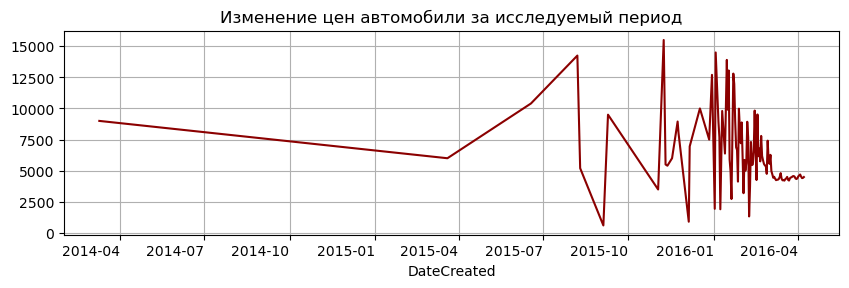

In [20]:
plt.figure(figsize=(10, 3)) 
df.groupby('DateCreated')['Price'].mean().plot(color=['#8B0000'], grid = True, rot=0)
plt.title('Изменение цен автомобили за исследуемый период', fontsize = '12')
plt.show()

Данные о цене за весь период очень хоатичны. Закономерности, что цена на авто выросла или упала, не прослеживается, стоит избавится и от этого столбца:

In [21]:
df.drop('DateCreated', axis=1, inplace=True)

Также можно удалить такой признак как количество фотографий на сайте, он никак не повлияет на цену. Стоит обратить внимание еще на такой признак, как почтовый индекс пользователя и посмотреть, зависит ли от этого цена на авто:

In [22]:
df.drop('NumberOfPictures', axis=1, inplace=True) # удаляем столбец с фотографиями

In [23]:
df.PostalCode.nunique() # всего уникальных почтовых индексов

8143

In [24]:
copy_df = df.copy() # будем использовать в дальнейшем этот датафрем для анализа данных
copy_df['cat_postal'] = pd.qcut(copy_df['PostalCode'],5)

In [25]:
copy_df.groupby('cat_postal')['Price'].agg(['mean','count']) # средняя цена по региону

,mean,count
cat_postal,,
"(1066.999, 26169.0]",4030.432423,70875
"(26169.0, 42389.0]",4146.269773,70956
"(42389.0, 56766.0]",4264.363901,70816
"(56766.0, 76185.0]",4688.365858,70869
"(76185.0, 99998.0]",4954.369688,70849


Как видим, цена все таки зависит от того региона, в котором находится владелец авто. Поэтому этот столбец трогать не будем, только переведем его тип из числа в категорию.

И еще один признак, который никак не повлияет на цену - это месяц регистрации авто. Удалим и его:

In [26]:
df.drop('RegistrationMonth', axis=1, inplace=True)

Посмотрим на итоговый датасет:

In [27]:
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,PostalCode
0,480,unknown,1993,manual,0,golf,150000,petrol,volkswagen,unknown,70435
1,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,yes,66954
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown,90480
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,91074
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,60437


## Выбросы

In [28]:
df.describe(include='all')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,PostalCode
count,354365.000000,354365,354365.000000,354365,354365.000000,354365,354365.000000,354365,354365,354365,354365.0
unique,NaN,9,NaN,3,NaN,251,NaN,8,40,3,8143.0
top,NaN,sedan,NaN,manual,NaN,golf,NaN,petrol,volkswagen,no,10115.0
freq,NaN,91457,NaN,268249,NaN,29232,NaN,216349,77012,247158,819.0
mean,4416.679830,NaN,2004.234481,NaN,110.093816,NaN,128211.363989,NaN,NaN,NaN,NaN
std,4514.176349,NaN,90.228466,NaN,189.851330,NaN,37905.083858,NaN,NaN,NaN,NaN
min,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,NaN,NaN,NaN,NaN
25%,1050.000000,NaN,1999.000000,NaN,69.000000,NaN,125000.000000,NaN,NaN,NaN,NaN
50%,2700.000000,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,NaN,NaN,NaN,NaN
75%,6400.000000,NaN,2008.000000,NaN,143.000000,NaN,150000.000000,NaN,NaN,NaN,NaN


In [29]:
numeric_columns = ['Price','RegistrationYear','Power','Kilometer']

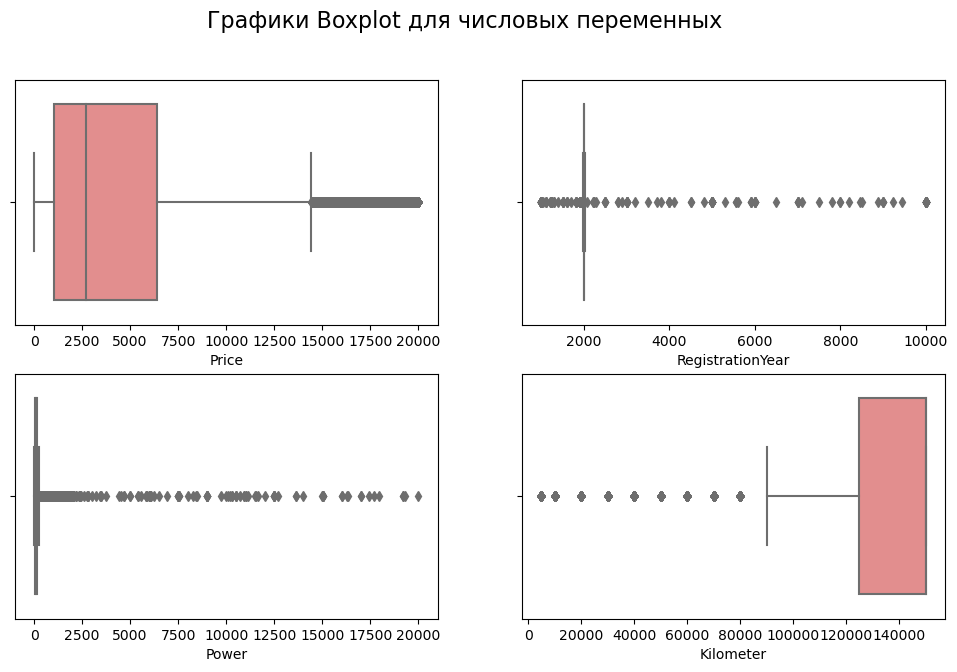

In [30]:
fig, axs = plt.subplots(2, 2, figsize=(12,7))
axs = axs.flatten()
for i, dt in enumerate(numeric_columns):
    sns.boxplot(df[dt], ax=axs[i], color='#F08080')

plt.suptitle('Графики Boxplot для числовых переменных', fontsize = '16')
plt.show()

Аномальные значения имеет столбец - мощность автомобиля, есть и нулевые значения и значения свыше 250 лошадиных сил. К сожалению аномалий слишком много, и если очистить от них датасет, уйдет 53625 элементов или 15% данных. Этот столбец можно удалить или попробовать привести к нормальному распределению и посмотреть, как он повлияет на модель в дальнейшем.

In [31]:
len(df[(df['Power']<50)|(df['Power']>250)])

53625

Признак RegistrationYear (год регистрации автомобиля) имеет ряд аномальных значений, например максимальное значение в столбце - 9999, а таже есть модели машин, зарегистрированные в 1950-90х годах. Предсказать цену на такие авто будет крайне сложно, так как это может быть машина как очень дорогая, если это к примеру коллекционная модель, так и наоборот, очень дешевая в силу неисправностей, связанных с возрастом. Посмотрим на количество автомобилей с аномальной датой регистрации в выборке:

In [32]:
len(df.loc[(copy_df['RegistrationYear'] < 1985) | (copy_df['RegistrationYear'] > 2016)])
#так как выгрузка была в 2016 году, все даты регистрации позже 2016 года - ошибочны

19978

Также есть и аномалии в столбце целевого признака - Цена автомобиля. А именно - в выборке есть автомобили, чья цена равна нулю или совсем низкая и не соответсвует действительности. Также посмотрим, сколько таких автомобилей всего:

In [33]:
len(df[df['Price']<=150])

16539

Удалим все автомобили из датасета, зарегистрированные до 1985 года и после 2016 года, а также все автомобили, чья цена равна нулю:

In [34]:
df = df[(df['RegistrationYear'] > 1985) & (df['RegistrationYear'] < 2017) & (df['Price']>=150)]
len(df)
# всего удалили не более 10% данных

320300

In [35]:
df.describe()

,Price,RegistrationYear,Power,Kilometer
count,320300.000000,320300.000000,320300.000000,320300.000000
mean,4632.487390,2003.106569,113.147409,128891.539182
std,4528.950299,5.763450,183.318124,36687.461971
min,150.000000,1986.000000,0.000000,5000.000000
25%,1200.000000,1999.000000,75.000000,125000.000000
50%,2950.000000,2003.000000,105.000000,150000.000000
75%,6666.000000,2007.000000,143.000000,150000.000000
max,20000.000000,2016.000000,20000.000000,150000.000000


Также приведем признак - мощность двигателя - к нормальному распределению:

In [36]:
df = df.assign(log_power = np.log(df.Power + 1))

In [37]:
df.drop('Power', axis=1, inplace=True)

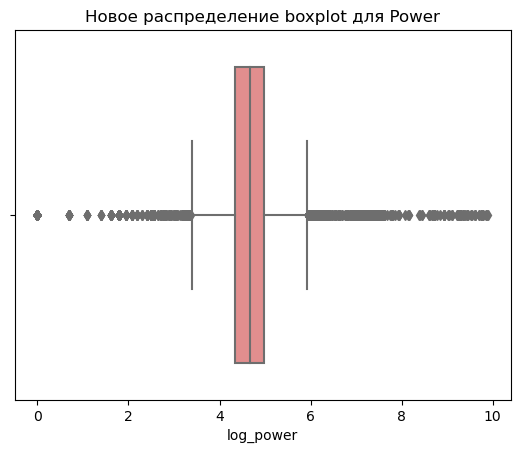

In [38]:
sns.boxplot(df['log_power'], color='#F08080')
plt.title('Новое распределение boxplot для Power')
plt.show()

Теперь распределение признака Power (столбец log_power, оригинальный столбец Power удален) выглядит нормальным. При этом в датасете сохранилось еще много элементов за пределами межквантильного размаха, поэтому в дальнейшем необходимо подбирать модели, устойчивые к выбросам.

## Взаимосвязи между признаками

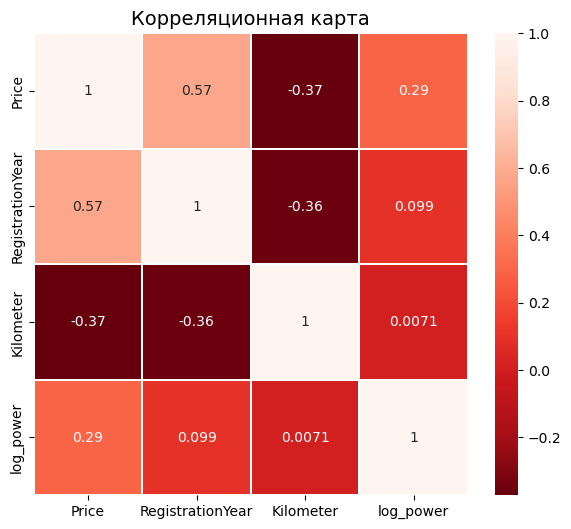

In [39]:
plt.figure(figsize = (7, 6))
sns.heatmap(df.corr(), annot = True, cmap = 'Reds_r', linewidths = 0.1)
plt.title('Корреляционная карта', fontsize = 14)
plt.show()

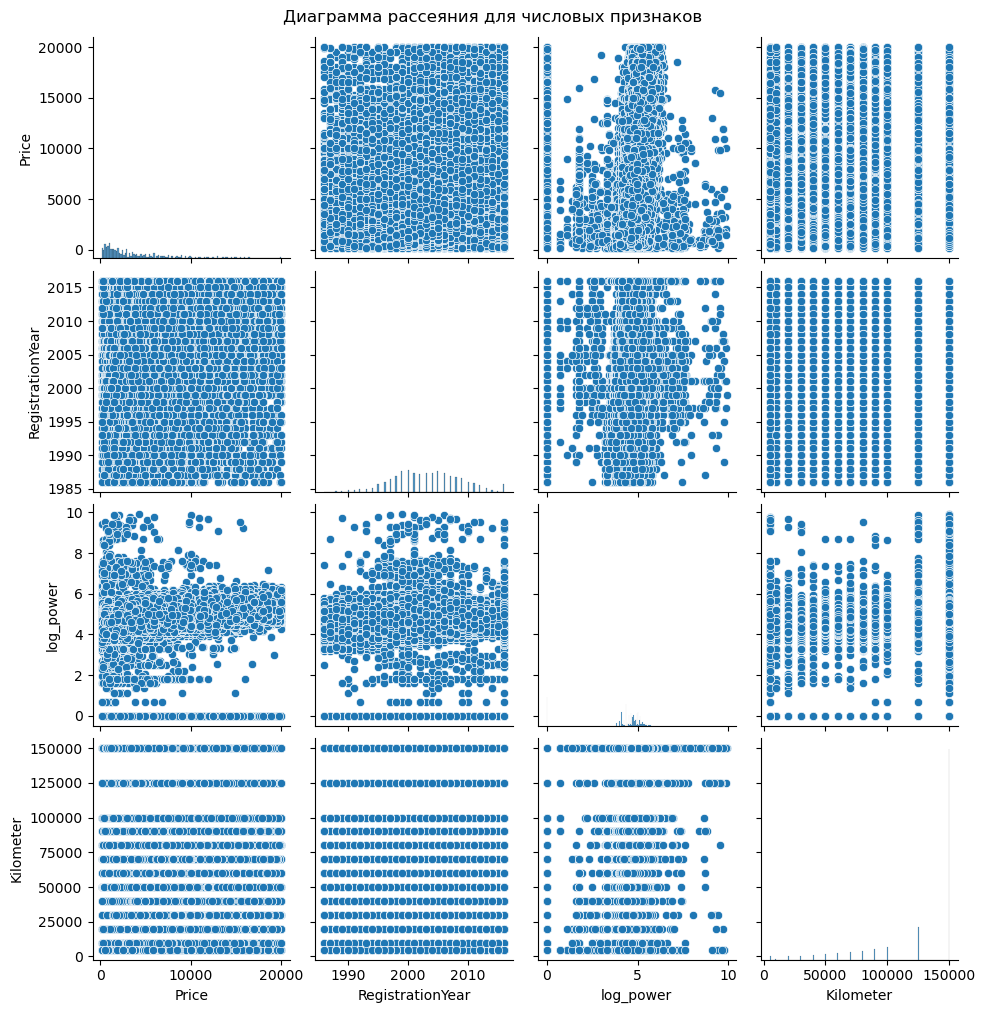

In [40]:
scatter = sns.pairplot(data=df[['Price','RegistrationYear','log_power','Kilometer']])
scatter.fig.suptitle("Диаграмма рассеяния для числовых признаков", y=1.01, size=12)
plt.show()

Коэффицент корреляции Пирсона показывает, что между ценой и признаками есть достаточно тесная взаимосвязь и все числовые признаки в данном датасете важны. Мультиколленеарности в данных нет, на диаграмме рассеивания четких линейных зависимостей не наблюдается, поэтому модели линейной регрессии могут показать не достаточную точность. Можно добавить категориальные признаки в зависимости от года регистрации автомобиля и пробега и сравнить, улучшит ли это модель. 

## Вывод:

Данные прошли предобработку и подготовлены к дальнейшему обучению модели машинного обучения. Пропуски заменены на заглушку - неизвестно, это создаст новую категорию для моделей. Удалены дубликаты и данные, которые не могут повлиять на цену автомобиля. Всем категориям присвоен соответствующий тип данных - категория. Проанализированы выбросы в данных, удалены аномалии в признаках, признак мощность двигателя приведен к нормальному распределению. Данные проверены на мультиколленеарность, проанализированы диаграммы рассеяния для числовых признаков. 

# Modeling

## Разделение на тестовую и обучающую выборки

In [41]:
X = df.drop(['Price'], axis = 1) #признаки
y = df.Price #целевая переменная

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42) # определим набор для тестирования

In [43]:
X_train.shape

(240225, 10)

In [44]:
X_test.shape

(80075, 10)

Итого для обучения нам доступно - 240667 элемента, для теста - 80223 элемента.

## Константная модель

Прежде, чем искать наилучшую модель, убедимся, что это оправдано, и выбранная модель будет работать лучше константного предсказания:

In [45]:
dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train, y_train)
y_pred = dummy.predict(X_test)
rmse_const = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_const

4535.628911764151

## SGDRegressor

Первая модель, которую мы проверим - SGDRegressor:

In [46]:
def objective(trial, data=X_train, target=y_train):
    
    X_tr, X_val, y_tr, y_val = train_test_split(data, target, test_size=0.25, random_state=42)
        
    # создадим контейнер трансформации отдельно для категориальных и числовых признаков
    cat_pipeline = make_pipeline(OneHotEncoder(handle_unknown="ignore")) #категориальные - переводим в числовые с помощью OHE 
    num_pipeline = make_pipeline(StandardScaler()) # числовые - масштабируем
    
    preprocessing = make_column_transformer( 
    (num_pipeline, make_column_selector(dtype_include=np.number)), 
    (cat_pipeline, make_column_selector(dtype_include='category'))) 

    X_tr_pr = preprocessing.fit_transform(X_tr)
    X_val_pr = preprocessing.transform(X_val)

    # Определяем параметры модели:
    params = {'penalty':'None', #штраф регуляризации не добавляется
            'random_state' : 42,
            'max_iter' : 1000, # кол-во итераций
            'tol': 1e-5, # остановка
            'n_iter_no_change' : 100, #кол-во итераций без улучшения до остановки
            'alpha': trial.suggest_loguniform('alpha', 1e-5, 1e-1), #сила регуляризации. Более высокое значение альфа приводит к более сильной регуляризации
            'l1_ratio': trial.suggest_uniform('l1_ratio', 0, 1), # Параметр смешивания эластичной сети
            'learning_rate' : trial.suggest_categorical('learning_rate', ['constant', 'optimal', 'invscaling', 'adaptive']), #график обучения
            'eta0': trial.suggest_loguniform('eta0', 1e-5, 1e-1) #начальная скорость обучения для расписаний constant, invscalingи adaptive
    }

    model = SGDRegressor(**params)

    start_time_fit = time.time()
    model.fit(X_tr_pr, y_tr)
    end_time_fit = time.time()
    training_time = end_time_fit - start_time_fit
    trial.set_user_attr('training_time', training_time)

    start_time_pred = time.time()
    y_pred = model.predict(X_val_pr)
    end_time_pred = time.time()
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    predict_time = end_time_pred - start_time_pred
    trial.set_user_attr('predict_time', predict_time)

    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5, n_jobs= -1)

print("Best parameters: ", study.best_params)
print('Best value: ', study.best_value)
sgd_rmse = study.best_value

total_training_time = sum([trial.user_attrs["training_time"] for trial in study.trials])
mean_training_time_sgd = total_training_time / len(study.trials)
print(f'Среднее время обучения : {mean_training_time_sgd:.2f} seconds')

total_predict_time = sum([trial.user_attrs["predict_time"] for trial in study.trials])
mean_predict_time_sgd = total_predict_time / len(study.trials)
print(f'Среднее время предсказания: {mean_predict_time_sgd:.2f} seconds')

[I 2023-03-06 13:24:04,050] A new study created in memory with name: no-name-7f1f8747-9a3e-4f41-8e43-50b9e6684a4a
[I 2023-03-06 13:24:18,796] Trial 1 finished with value: 2817.7102918894884 and parameters: {'alpha': 0.0004340017763579872, 'l1_ratio': 0.5482610712868838, 'learning_rate': 'constant', 'eta0': 0.031697406616555936}. Best is trial 1 with value: 2817.7102918894884.
[I 2023-03-06 13:24:29,634] Trial 0 finished with value: 2661.3384294697926 and parameters: {'alpha': 3.2625582714436355e-05, 'l1_ratio': 0.2175107559085383, 'learning_rate': 'constant', 'eta0': 0.014539379909552235}. Best is trial 0 with value: 2661.3384294697926.
[I 2023-03-06 13:25:27,388] Trial 2 finished with value: 2571.572597564755 and parameters: {'alpha': 0.03636965994795968, 'l1_ratio': 0.2626787265351157, 'learning_rate': 'adaptive', 'eta0': 0.03267144227223467}. Best is trial 2 with value: 2571.572597564755.
[I 2023-03-06 13:25:27,527] Trial 3 finished with value: 2571.5601673996266 and parameters: {'a

Best parameters:  {'alpha': 6.74304304966718e-05, 'l1_ratio': 0.8584928974430418, 'learning_rate': 'adaptive', 'eta0': 0.0049813032357227845}
Best value:  2569.5576169936126
Среднее время обучения : 56.43 seconds
Среднее время предсказания: 0.00 seconds


## VotingRegressor(на основе DecisionTreeRegressor, HuberRegressor)

Попробуем применить такой ансамблиевый классификатор как VotingRegressor. Он будет подбирать цену для автомобиля основываясь на данных полученных от моделей - DecisionTreeRegressor и HuberRegressor(модель линейной регрессии, устойчивая к выбросам):

In [47]:
def objective(trial, data=X_train, target=y_train):
    X_tr, X_val, y_tr, y_val = train_test_split(data, target, test_size=0.25, random_state=42)

    # также необходима трансформация данных
    cat_pipeline = make_pipeline(OneHotEncoder(handle_unknown="ignore")) #категориальные - переводим в числовые с помощью OHE 
    num_pipeline = make_pipeline(StandardScaler()) # числовые - масштабируем
    
    preprocessing = make_column_transformer( 
    (num_pipeline, make_column_selector(dtype_include=np.number)), 
    (cat_pipeline, make_column_selector(dtype_include='category'))) 

    X_tr_pr = preprocessing.fit_transform(X_tr)
    X_val_pr = preprocessing.transform(X_val)

    dt_params = {
            'random_state' : 42,
            'max_depth': trial.suggest_int('max_depth', 1, 10), # глубина дерева
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20), #определяет минимальное количество выборок, необходимых для разделения внутреннего узла.
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 10)} #указывает минимальное количество выборок, необходимых для конечного узла
        
    #mlp_params = {
            #'solver': 'sgd',
            #'random_state' : 42}
            #'hidden_layer_sizes': trial.suggest_int('hidden_layer_sizes', 80, 100, step = 10), #кортеж, определяющий количество нейронов в каждом скрытом слое нейронной сети
            #'alpha': trial.suggest_loguniform('alpha', 1e-3 , 1e-1)} #параметр регуляризации L2 нейронной сети
    
    huber_params = {
            'epsilon': trial.suggest_uniform('epsilon', 1, 3), #чувствительность функции потерь к выбросам
            'alpha': trial.suggest_loguniform('alpha', 1e-5, 1e-1)} #параметр регуляризации
        
    dt = DecisionTreeRegressor(**dt_params)
    #mlp = MLPRegressor(**mlp_params)
    huber = HuberRegressor(**huber_params)

    vr = VotingRegressor([('dt', dt), #('mlp', mlp), 
                          ('huber', huber)])
    start_time_fit = time.time()
    vr.fit(X_tr_pr, y_tr)
    end_time_fit = time.time()
    training_time = end_time_fit - start_time_fit
    trial.set_user_attr('training_time', training_time)

    start_time_pred = time.time()
    y_pred = vr.predict(X_val_pr)
    end_time_pred = time.time()
    predict_time = end_time_pred - start_time_pred
    trial.set_user_attr('predict_time', predict_time)

    rmse = np.sqrt(mean_squared_error(y_val, y_pred))

    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5, n_jobs= -1)

print("Best parameters: ", study.best_params)
print('Best value: ', study.best_value) 
vot_rmse = study.best_value

total_training_time = sum([trial.user_attrs["training_time"] for trial in study.trials])
mean_training_time_vot = total_training_time / len(study.trials)
print(f'Среднее время обучения : {mean_training_time_vot:.2f} seconds')

total_predict_time = sum([trial.user_attrs["predict_time"] for trial in study.trials])
mean_predict_time_vot = total_predict_time / len(study.trials)
print(f'Среднее время предсказания: {mean_predict_time_vot:.2f} seconds')

[I 2023-03-06 13:25:30,418] A new study created in memory with name: no-name-f20db536-8e66-4234-82cc-e7c050b3b129
[I 2023-03-06 13:25:47,982] Trial 0 finished with value: 2848.727063057963 and parameters: {'max_depth': 1, 'min_samples_split': 7, 'min_samples_leaf': 10, 'epsilon': 1.012335386214485, 'alpha': 0.009677383809765449}. Best is trial 0 with value: 2848.727063057963.
[I 2023-03-06 13:25:49,434] Trial 3 finished with value: 2790.653318819682 and parameters: {'max_depth': 1, 'min_samples_split': 6, 'min_samples_leaf': 6, 'epsilon': 2.240704793495632, 'alpha': 0.06484675150499727}. Best is trial 3 with value: 2790.653318819682.
[I 2023-03-06 13:25:53,355] Trial 4 finished with value: 2484.943634589338 and parameters: {'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 5, 'epsilon': 1.1521790356148418, 'alpha': 0.06110901325356887}. Best is trial 4 with value: 2484.943634589338.
[I 2023-03-06 13:25:54,335] Trial 1 finished with value: 2152.0771945476913 and parameters: {'

Best parameters:  {'max_depth': 5, 'min_samples_split': 14, 'min_samples_leaf': 9, 'epsilon': 1.9965403378376017, 'alpha': 8.896605745188246e-05}
Best value:  2145.1990695406457
Среднее время обучения : 19.27 seconds
Среднее время предсказания: 0.02 seconds


In [48]:
# использовала в качестве эксперемента этот метод, прочитала и захотелось попробовать, в коде еще была модель MLPRegressor, но мой комп ее 
# не потянул, я так и не поняла, почему, вроде как она работает с большими данными. 
# Если можно, напиши, стоит ли ее вообще применять для этих данных?

## CatBoost

Попробуем применить градиентный бустинг и модель CatBoostRegressor. Для этой модель стандартизация и кодирование данных не требуется.

In [49]:
# необходимо выделить категории в отдельный список
categorical_features_in= np.where((X.dtypes != float) & (X.dtypes != int))[0]

In [50]:
def objective(trial, data=X_train, target=y_train):
    X_tr, X_val, y_tr, y_val = train_test_split(data, target, test_size=0.25, random_state=42)

    params = { 
        'loss_function': 'RMSE', #функция потерь, которая будет использоваться для оптимизации модели  
        'eval_metric': 'RMSE', #оценка производительности модели     
        'random_seed': 42, 
        'learning_rate': trial.suggest_categorical ('learning_rate', [0.08, 0.1, 0.2]), #контролирует размер шага на каждой итерации, оптимизируя функцию потерь.
        'iterations': trial.suggest_int ('iterations', 200, 1000), #устанавливает количество итераций повышения
        'early_stopping_rounds': 20, # устанавливает количество раундов ожидания улучшения оценки проверки перед остановкой процесса обучения.
        'max_depth': trial.suggest_int('max_depth', 3, 10, step=2), #устанавливает максимальную глубину дерева решений
        #'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.0001, 1.0, log = True), # устанавливает параметр регуляризации L2 для весов листьев.
        #'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 5), #управляет интенсивностью процесса начальной загрузки
        #'random_strength': trial.suggest_float('random_strength', 0, 5), #Более высокая случайная сила приводит к более надежной модели, которая менее чувствительна к зашумленным входным функциям.       
        'verbose': False #  во время обучения вывод не будет напечатан.
         }
   
    
    model = CatBoostRegressor(**params)

    start_time_fit = time.time()
    model.fit(X_tr, y_tr,  
    cat_features=categorical_features_in,
    eval_set = (X_val, y_val))
    end_time_fit = time.time()
    training_time = end_time_fit - start_time_fit
    trial.set_user_attr('training_time', training_time)
    
    start_time_pred = time.time()
    y_pred = model.predict(X_val)
    end_time_pred = time.time()
    predict_time = end_time_pred - start_time_pred
    trial.set_user_attr('predict_time', predict_time)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))

    return rmse
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5, n_jobs= -1)

print("Best parameters: ", study.best_params)
print('Best value: ', study.best_value)
cat_rmse = study.best_value

total_training_time = sum([trial.user_attrs["training_time"] for trial in study.trials])
mean_training_time_cat = total_training_time / len(study.trials)
print(f'Среднее время обучения : {mean_training_time_cat:.2f} seconds')

total_predict_time = sum([trial.user_attrs["predict_time"] for trial in study.trials])
mean_predict_time_cat = total_predict_time / len(study.trials)
print(f'Среднее время предсказания: {mean_predict_time_cat:.2f} seconds')

[I 2023-03-06 13:25:54,835] A new study created in memory with name: no-name-045b9a1f-234d-4732-8aef-9ed112d61502
[I 2023-03-06 13:30:20,544] Trial 1 finished with value: 1728.1988265555262 and parameters: {'learning_rate': 0.08, 'iterations': 360, 'max_depth': 3}. Best is trial 1 with value: 1728.1988265555262.
[I 2023-03-06 13:30:36,467] Trial 0 finished with value: 1709.2846936757464 and parameters: {'learning_rate': 0.08, 'iterations': 443, 'max_depth': 3}. Best is trial 1 with value: 1728.1988265555262.
[I 2023-03-06 13:32:18,688] Trial 4 finished with value: 1549.5586470400121 and parameters: {'learning_rate': 0.2, 'iterations': 224, 'max_depth': 7}. Best is trial 1 with value: 1728.1988265555262.
[I 2023-03-06 13:36:18,355] Trial 3 finished with value: 1531.6066560006893 and parameters: {'learning_rate': 0.2, 'iterations': 759, 'max_depth': 5}. Best is trial 1 with value: 1728.1988265555262.
[I 2023-03-06 13:36:56,796] Trial 2 finished with value: 1501.690250662307 and parameter

Best parameters:  {'learning_rate': 0.08, 'iterations': 360, 'max_depth': 3}
Best value:  1728.1988265555262
Среднее время обучения : 442.24 seconds
Среднее время предсказания: 0.53 seconds


## LightGBM

Последняя модель, на которой мы попробуем предсказать цену автомобиля - LGBMRegressor:

In [51]:
def objective(trial, data=X_train, target=y_train):
    
    X_tr, X_val, y_tr, y_val = train_test_split(data, target, test_size=0.25, random_state=42)
    

    #основные параметры для модели
    params = {
        'random_seed': 42,
        "metric": "rmse", # метрика, подлежащая оценке в оценочном наборе,
        "n_estimators": trial.suggest_categorical("n_estimators", [1000]), #кол-во итераций
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3), # cкорость обучения (параметр регурялизации модели)
        #"num_leaves": trial.suggest_int("num_leaves", 20, 300, step=10), #максимальное количество листьев на одном дереве - вляет на качетсво обучения (переобучится модель или нет)
        "max_depth": trial.suggest_int("max_depth", 3, 10), #ограничивает максимальную глубину для модели дерева
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 10), #минимальное количество данных в одном листе. Может использоваться для борьбы с чрезмерной подгонкой.
        #"lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 10.0), #регуляризация Лассо (использование только наиболее информативных функций)
        #"lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-8, 10.0), #регуляризация Риджа (уменьшает влияние зашумленных или нерелевантных функций)
        #"feature_fraction": trial.suggest_uniform("feature_fraction", 0.1, 1.0), # может быть использован для борьбы с переоснащением (переобучением)
        #"bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.1, 1.0), # может помочь уменьшить дисперсию модели и повысить ее стабильность, 
        #сделав каждое дерево более разнообразным и менее зависимым от конкретной выборки наблюдений
        "num_threads": -1, #n_jobs (ядра процессора)
        "verbose": -1
    }

   
    model = LGBMRegressor(**params)
    
    start_time_fit = time.time()
    model.fit(X_tr, y_tr, eval_set = [(X_val, y_val)])
    end_time_fit = time.time()
    training_time = end_time_fit - start_time_fit
    trial.set_user_attr('training_time', training_time)
    
    start_time_pred = time.time()
    y_pred = model.predict(X_val)
    end_time_pred = time.time()
    predict_time = end_time_pred - start_time_pred
    trial.set_user_attr('predict_time', predict_time)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))

    return rmse


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5)

print("Best parameters: ", study.best_params)
print('Best value: ', study.best_value)
lgbm_rmse = study.best_value

total_training_time = sum([trial.user_attrs["training_time"] for trial in study.trials])
mean_training_time_lgdm = total_training_time / len(study.trials)
print(f'Среднее время обучения : {mean_training_time_lgdm:.2f} seconds')

total_predict_time = sum([trial.user_attrs["predict_time"] for trial in study.trials])
mean_predict_time_lgbm = total_predict_time / len(study.trials)
print(f'Среднее время предсказания: {mean_predict_time_lgbm:.2f} seconds')

[I 2023-03-06 13:36:56,930] A new study created in memory with name: no-name-2cb25c3f-76b6-4ed6-a971-62654e0fb72f


[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[1]	valid_0's rmse: 3715.61
[2]	valid_0's rmse: 3146.94
[3]	valid_0's rmse: 2725.31
[4]	valid_0's rmse: 2433.08
[5]	valid_0's rmse: 2228.25
[6]	valid_0's rmse: 2078.54
[7]	valid_0's rmse: 1972.4
[8]	valid_0's rmse: 1897.98
[9]	valid_0's rmse: 1841.09
[10]	valid_0's rmse: 1802.49
[11]	valid_0's rmse: 1767.59
[12]	valid_0's rmse: 1739.91
[13]	valid_0's rmse: 1721.91
[14]	valid_0's rmse: 1709.1
[15]	valid_0's rmse: 1696.64
[16]	valid_0's rmse: 1687.46
[17]	valid_0's rmse: 1677.2
[18]	valid_0's rmse: 1674.31
[19]	valid_0's rmse: 1669.67
[20]	valid_0's rmse: 1662.52
[21]	valid_0's rmse: 1659.2
[22]	valid_0's rmse: 1654.92
[23]	valid_0's rmse: 1652.37
[24]	valid_0's rmse: 1649.79
[25]	valid_0's rmse: 1647.51
[26]	valid_0's rmse: 1644.51
[27]	valid_0's rmse: 1642.51
[28]	valid_0's rmse: 1641.71
[29]	valid_0's rmse: 1640
[30]	valid_0's rmse: 1637.09
[31]	valid_0's rmse: 1636.34
[32]	valid_0's r

[I 2023-03-06 13:37:09,210] Trial 0 finished with value: 1573.3350658511365 and parameters: {'n_estimators': 1000, 'learning_rate': 0.24875649454104848, 'max_depth': 6, 'min_child_samples': 5}. Best is trial 0 with value: 1573.3350658511365.


[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[1]	valid_0's rmse: 3592.95
[2]	valid_0's rmse: 2982.18
[3]	valid_0's rmse: 2560.56
[4]	valid_0's rmse: 2283.06
[5]	valid_0's rmse: 2095.87
[6]	valid_0's rmse: 1972.87
[7]	valid_0's rmse: 1883.43
[8]	valid_0's rmse: 1824.94
[9]	valid_0's rmse: 1778.22
[10]	valid_0's rmse: 1747.03
[11]	valid_0's rmse: 1724.28
[12]	valid_0's rmse: 1705.94
[13]	valid_0's rmse: 1697.33
[14]	valid_0's rmse: 1683.96
[15]	valid_0's rmse: 1677.89
[16]	valid_0's rmse: 1671.26
[17]	valid_0's rmse: 1665.65
[18]	valid_0's rmse: 1662.31
[19]	valid_0's rmse: 1658.2
[20]	valid_0's rmse: 1655.79
[21]	valid_0's rmse: 1654.91
[22]	valid_0's rmse: 1650.38
[23]	valid_0's rmse: 1646.39
[24]	valid_0's rmse: 1641.77
[25]	valid_0's rmse: 1640.81
[26]	valid_0's rmse: 1640.39
[27]	valid_0's rmse: 1639.06
[28]	valid_0's rmse: 1637.13
[29]	valid_0's rmse: 1636.72
[30]	valid_0's rmse: 1631.19
[31]	valid_0's rmse: 1629.97
[32]	valid

[I 2023-03-06 13:37:21,057] Trial 1 finished with value: 1580.53944278266 and parameters: {'n_estimators': 1000, 'learning_rate': 0.2882300244182621, 'max_depth': 6, 'min_child_samples': 5}. Best is trial 1 with value: 1580.53944278266.


[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[1]	valid_0's rmse: 4419.16
[2]	valid_0's rmse: 4308.37
[3]	valid_0's rmse: 4201.51
[4]	valid_0's rmse: 4099.43
[5]	valid_0's rmse: 4002.86
[6]	valid_0's rmse: 3909.11
[7]	valid_0's rmse: 3819.68
[8]	valid_0's rmse: 3734.39
[9]	valid_0's rmse: 3650.72
[10]	valid_0's rmse: 3571.97
[11]	valid_0's rmse: 3494.49
[12]	valid_0's rmse: 3420.81
[13]	valid_0's rmse: 3350.94
[14]	valid_0's rmse: 3282.93
[15]	valid_0's rmse: 3218.76
[16]	valid_0's rmse: 3155.79
[17]	valid_0's rmse: 3094.78
[18]	valid_0's rmse: 3036.64
[19]	valid_0's rmse: 2980.29
[20]	valid_0's rmse: 2927.35
[21]	valid_0's rmse: 2875.87
[22]	valid_0's rmse: 2826.4
[23]	valid_0's rmse: 2779.9
[24]	valid_0's rmse: 2734.9
[25]	valid_0's rmse: 2690.9
[26]	valid_0's rmse: 2649.46
[27]	valid_0's rmse: 2610.24
[28]	valid_0's rmse: 2572.17
[29]	valid_0's rmse: 2535.05
[30]	valid_0's rmse: 2500.17
[31]	valid_0's rmse: 2466.14
[32]	valid_0'

[I 2023-03-06 13:37:35,029] Trial 2 finished with value: 1553.2635094355446 and parameters: {'n_estimators': 1000, 'learning_rate': 0.034068189423813795, 'max_depth': 6, 'min_child_samples': 5}. Best is trial 1 with value: 1580.53944278266.


[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[1]	valid_0's rmse: 3841
[2]	valid_0's rmse: 3319.57
[3]	valid_0's rmse: 2924.75
[4]	valid_0's rmse: 2620.87
[5]	valid_0's rmse: 2393.21
[6]	valid_0's rmse: 2222.48
[7]	valid_0's rmse: 2097.38
[8]	valid_0's rmse: 1996.81
[9]	valid_0's rmse: 1919.89
[10]	valid_0's rmse: 1862.91
[11]	valid_0's rmse: 1818.22
[12]	valid_0's rmse: 1781.35
[13]	valid_0's rmse: 1753.68
[14]	valid_0's rmse: 1729.3
[15]	valid_0's rmse: 1710.95
[16]	valid_0's rmse: 1698.22
[17]	valid_0's rmse: 1687.04
[18]	valid_0's rmse: 1674.99
[19]	valid_0's rmse: 1666.35
[20]	valid_0's rmse: 1657.88
[21]	valid_0's rmse: 1652.17
[22]	valid_0's rmse: 1649.01
[23]	valid_0's rmse: 1644.66
[24]	valid_0's rmse: 1641.76
[25]	valid_0's rmse: 1636.6
[26]	valid_0's rmse: 1633.83
[27]	valid_0's rmse: 1629.93
[28]	valid_0's rmse: 1626.99
[29]	valid_0's rmse: 1623.77
[30]	valid_0's rmse: 1622.4
[31]	valid_0's rmse: 1620.14
[32]	valid_0's 

[I 2023-03-06 13:37:50,082] Trial 3 finished with value: 1554.9270526102534 and parameters: {'n_estimators': 1000, 'learning_rate': 0.20917490761754653, 'max_depth': 8, 'min_child_samples': 9}. Best is trial 1 with value: 1580.53944278266.


[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[1]	valid_0's rmse: 4417.76
[2]	valid_0's rmse: 4306.77
[3]	valid_0's rmse: 4199.97
[4]	valid_0's rmse: 4099.52
[5]	valid_0's rmse: 4001.97
[6]	valid_0's rmse: 3910.04
[7]	valid_0's rmse: 3821.6
[8]	valid_0's rmse: 3738.18
[9]	valid_0's rmse: 3658.47
[10]	valid_0's rmse: 3582.8
[11]	valid_0's rmse: 3510.61
[12]	valid_0's rmse: 3438.61
[13]	valid_0's rmse: 3370.35
[14]	valid_0's rmse: 3302.68
[15]	valid_0's rmse: 3241.71
[16]	valid_0's rmse: 3183.69
[17]	valid_0's rmse: 3123.96
[18]	valid_0's rmse: 3067.92
[19]	valid_0's rmse: 3017.02
[20]	valid_0's rmse: 2965.8
[21]	valid_0's rmse: 2918.1
[22]	valid_0's rmse: 2873.7
[23]	valid_0's rmse: 2829.43
[24]	valid_0's rmse: 2785.43
[25]	valid_0's rmse: 2744.33
[26]	valid_0's rmse: 2704.66
[27]	valid_0's rmse: 2668.92
[28]	valid_0's rmse: 2633.6
[29]	valid_0's rmse: 2600.95
[30]	valid_0's rmse: 2567.94
[31]	valid_0's rmse: 2536.62
[32]	valid_0's 

[I 2023-03-06 13:38:00,688] Trial 4 finished with value: 1605.0806414098415 and parameters: {'n_estimators': 1000, 'learning_rate': 0.03730618852746213, 'max_depth': 4, 'min_child_samples': 7}. Best is trial 4 with value: 1605.0806414098415.


Best parameters:  {'n_estimators': 1000, 'learning_rate': 0.03730618852746213, 'max_depth': 4, 'min_child_samples': 7}
Best value:  1605.0806414098415
Среднее время обучения : 11.41 seconds
Среднее время предсказания: 1.24 seconds


## Вывод:

In [52]:
model_scores = pd.DataFrame({'Model':['SGDRegressor', 'VotingRegressor', 'CatBoostRegressor', 'LGBMRegressor'],
                             'RMSE': [sgd_rmse, vot_rmse, cat_rmse, lgbm_rmse], 
                            'Время обучения, сек': [round(mean_training_time_sgd, 2), round(mean_training_time_vot, 2), 
                                                    round(mean_training_time_cat, 2), round(mean_training_time_lgdm, 2)], 
                            'Cкорость предсказания, сек': [round(mean_predict_time_sgd, 2), round(mean_predict_time_vot, 2), 
                                                    round(mean_predict_time_cat, 2), round(mean_predict_time_lgbm, 2)]})
model_scores

,Model,RMSE,"Время обучения, сек","Cкорость предсказания, сек"
0,SGDRegressor,2569.557617,56.43,0.00
1,VotingRegressor,2145.199070,19.27,0.02
2,CatBoostRegressor,1728.198827,442.24,0.53
3,LGBMRegressor,1605.080641,11.41,1.24


Было исследовано четыре модели:

- SGDRegressor
- VotingRegressor(на основе DecisionTreeRegressor, HuberRegressor)
- CatBoostRegressor
- LGBMRegressor

Модель линейной регрессии не соответсвует требованиям качества, что и следовало ожидать, так как в данных нет сильных линейных связей. Эту модель можно улучшить с помощью feature engineering, например добавить новые категории на основании года регистрации авто и пробега авто. Остальные модели удовлитворили требования заказчика и могут быть пременяны на практике, однако модель LGBMRegressor показыает достаточно хорошее качество на контрольной метрике RMSE, и при этом обучается намного быстрее, чем все остальные модели. Время предсказания немного дольше, чем у других, но это компенсируется временем обучения. Однозначно, для целей проекта эта модель подходит больше всего.

Также можно отметить, что если бы не стояло условия о времени обучения, стоило бы предпочесть CatBoost как более надежную модель, работающую с имеющимися данными. 

# Оценка на тестовом наборе

In [53]:
best_params = study.best_params
final_model = LGBMRegressor(n_estimators = best_params['n_estimators'], 
                            learning_rate = best_params['learning_rate'],
                            #num_leaves = best_params['num_leaves'],
                            max_depth = best_params['max_depth'], 
                            min_child_samples = best_params['min_child_samples'], 
                            #lambda_l1 = best_params['lambda_l1'],
                            #lambda_l2 = best_params['lambda_l2'],
                            #feature_fraction = best_params['feature_fraction'],
                            #bagging_fraction = best_params['bagging_fraction']
                            )

In [54]:
start_time = time.time()
final_model.fit(X_train, y_train) 
end_time = time.time()
fit_time = end_time - start_time
print('Время выполнения: {:.2f} seconds'.format(fit_time))

Время выполнения: 10.58 seconds


In [55]:
start_time = time.time()
final_predictions = final_model.predict(X_test)
end_time = time.time()
pred_time = end_time - start_time
print('Время выполнения: {:.2f} seconds'.format(pred_time))

Время выполнения: 1.15 seconds


In [56]:
final_rmse = mean_squared_error(y_test, final_predictions, squared=False) 
print(final_rmse)

1579.3990405773168


In [57]:
final_scores = pd.DataFrame({'RMSE': [final_rmse], 
                            'Время обучения, сек': [round(fit_time, 2)], 
                            'Cкорость предсказания, сек': [round(pred_time, 2)]})
final_scores

,RMSE,"Время обучения, сек","Cкорость предсказания, сек"
0,1579.399041,10.58,1.15


Модель успешно прошла оценку на тестовом наборе. Cохраним ее для дальнейшего использования:

In [58]:
joblib.dump(final_model, "my_auto_price_model.pkl") 

['my_auto_price_model.pkl']

# Анализ ошибок модели

## Создание датасета для анализа

In [59]:
df_test = X_test.copy() # создадим новый датафрейм для анализа

In [60]:
pred_price = pd.Series(final_predictions) #массив с предсказаниями завернем Series для присоединения к датасету

In [61]:
y_test = y_test.reset_index() #обновим индексы для значения цены
y_test.drop('index', axis=1, inplace=True)

In [62]:
# присоединим данные
df_test['real_price'] = y_test
df_test['pred_price'] = pred_price

In [63]:
df_test.head() #посмотрим на полученный датасет

,VehicleType,RegistrationYear,Gearbox,Model,Kilometer,FuelType,Brand,Repaired,PostalCode,log_power,real_price,pred_price
162957,sedan,2003,manual,a3,150000,petrol,audi,no,86946,4.634729,NaN,NaN
56960,sedan,1998,auto,e_klasse,5000,lpg,mercedes_benz,unknown,45665,5.323010,4100.0,4506.122772
33415,sedan,2007,manual,astra,150000,petrol,opel,no,32257,5.192957,1200.0,947.872412
296066,small,2005,manual,twingo,150000,petrol,renault,no,88214,4.330733,NaN,NaN
259547,small,1998,manual,fiesta,150000,petrol,ford,no,59227,4.330733,NaN,NaN


## Ошибка предсказания

In [64]:
df_test['error'] = df_test.pred_price - df_test.real_price

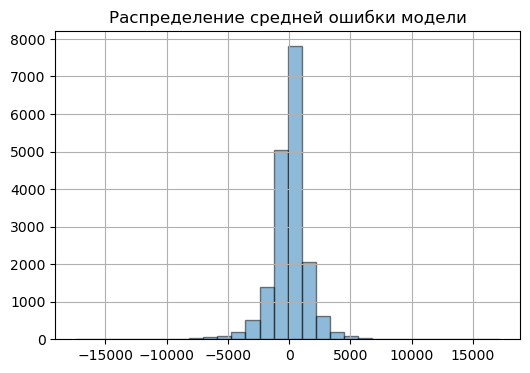

In [65]:
df_test.error.hist(bins = 30, grid=True, alpha=0.5, edgecolor='black', figsize=(6,4))
plt.title('Распределение средней ошибки модели')
plt.show()

In [66]:
df_test.error.mean()

4.669259455236511

Большинство значений ошибки лежит в пределах нуля. Модель в среднем чаще завышает стоимость автомобиля.

## Абсолютная ошибка

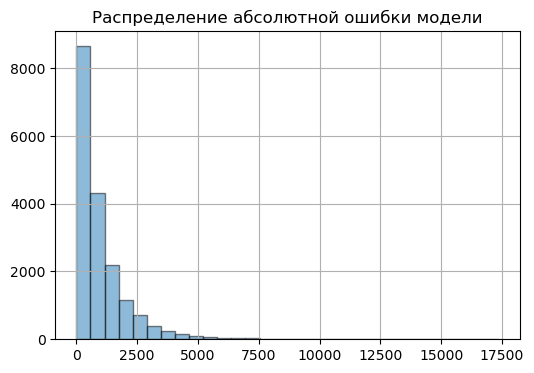

In [67]:
df_test['error_abs'] = abs(df_test.error) # абсолютная ошибка модели (не учитывает, занижает модель или завышает цену)
df_test.error_abs.hist(bins = 30, grid=True, alpha=0.5, edgecolor='black', figsize=(6,4))
plt.title('Распределение абсолютной ошибки модели')
plt.show()

In [68]:
df_test.error_abs.describe()

count    18163.000000
mean      1005.514649
std       1229.798556
min          0.005737
25%        269.754954
50%        621.236012
75%       1292.650875
max      17375.456462
Name: error_abs, dtype: float64

Модель ошиблась в некоторых случаях почти на 20000. То есть каким-то автомобилям присвоена слишком высокая цена. Медианное значение ошибки - 638, что уже не так много. В основном модель все-таки присваеват цену верно.

## Топ-10 ошибок

In [69]:
df_test.sort_values('error_abs', ascending=False).head(10)

,VehicleType,RegistrationYear,Gearbox,Model,Kilometer,FuelType,Brand,Repaired,PostalCode,log_power,real_price,pred_price,error,error_abs
60890,unknown,2016,auto,3_reihe,150000,unknown,peugeot,unknown,55779,0.000000,20000.0,2624.543538,-17375.456462,17375.456462
69289,sedan,2012,manual,a_klasse,100000,gasoline,mercedes_benz,no,40699,4.919981,639.0,17770.163421,17131.163421,17131.163421
75589,unknown,2016,manual,passat,150000,gasoline,volkswagen,no,25557,4.510860,19990.0,3358.361999,-16631.638001,16631.638001
57141,wagon,2000,manual,passat,150000,gasoline,volkswagen,no,91452,4.709530,420.0,16338.302455,15918.302455,15918.302455
27207,unknown,2016,unknown,passat,150000,unknown,volkswagen,unknown,41751,4.753590,20000.0,4580.602313,-15419.397687,15419.397687
35158,sedan,2008,manual,fabia,125000,petrol,skoda,no,65824,4.110874,593.0,15617.094451,15024.094451,15024.094451
2478,wagon,2003,manual,a4,150000,gasoline,audi,yes,38226,4.882802,458.0,14848.049723,14390.049723,14390.049723
41439,bus,2007,manual,c_max,150000,gasoline,ford,no,53879,4.510860,19900.0,5676.219616,-14223.780384,14223.780384
25150,small,1996,manual,corsa,150000,petrol,opel,no,58809,3.828641,250.0,14200.137883,13950.137883,13950.137883
77593,coupe,2002,manual,3er,150000,petrol,bmw,no,56070,5.141664,280.0,13704.467847,13424.467847,13424.467847


Если посмотреть на топ-10 ошибок модели, то сразу можно сказать, что модель ошибается на тех машинах, чья цена сильно занижена, понять насколько это реальная цена, сложно, возможно машина на момент продажи повреждена, возможно цена действительно выставлена ошибочно. Также есть другая ошибка, когда реальная цена 20000, а модель предсказала намного меньше. Можно посмотреть на гистограмму распределения цены на любой автомобиль в топ-10:

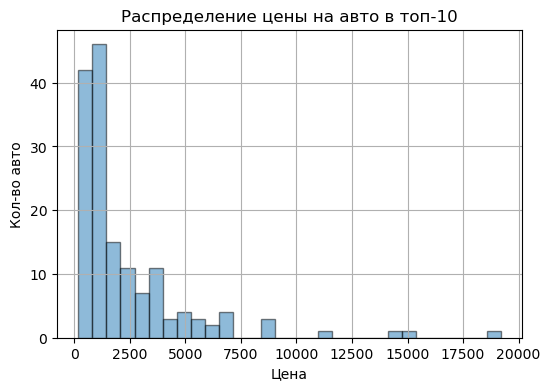

In [86]:
df[(df['Model']=='passat')&(df['RegistrationYear']==2016)]['Price'].hist(bins = 30, grid=True, alpha=0.5, edgecolor='black', figsize=(6,4))
plt.title('Распределение цены на авто в топ-10')
plt.xlabel('Цена')
plt.ylabel('Кол-во авто')
plt.show()

Сильный разбег цен на автомобиль, много  выбросов за пределом значений в 5000. В результате либо недостаточно признаков для формирования закономерностей или владельцы сильно завышают цены на свои автомобили, что приводит к такой большой ошибке RMSE. 

Посмотрим, какие признаки влияют на цену:

In [71]:
def analitic(col):
   s = df_test.groupby(col)[['error_abs', 'error']].agg(['count', 'mean'])
   s.columns = ['_'.join(col) for col in s.columns.values]
   s = s.drop('error_count', axis=1)
   s['mean_error_diff'] = s['error_abs_mean']-df_test['error_abs'].mean()
   s["mean_error"] = df_test['error_abs'].mean()
   cm = sns.dark_palette("red", as_cmap=True)
   display(s.style.background_gradient(cmap=cm, subset=['mean_error_diff']))

In [72]:
df_test['year_group'] = pd.qcut(df_test['RegistrationYear'],10) # год регистрации

In [73]:
analitic('year_group')

,error_abs_count,error_abs_mean,error_mean,mean_error_diff,mean_error
year_group,,,,,
"(1985.999, 1996.0]",2114,990.197065,47.125159,-15.317584,1005.514649
"(1996.0, 1998.0]",1681,987.828325,-44.046807,-17.686324,1005.514649
"(1998.0, 2000.0]",2517,1023.669724,-5.921373,18.155075,1005.514649
"(2000.0, 2001.0]",1084,956.859387,-8.705678,-48.655262,1005.514649
"(2001.0, 2003.0]",2189,983.561142,17.039596,-21.953507,1005.514649
"(2003.0, 2005.0]",2293,1000.686200,9.719428,-4.828449,1005.514649
"(2005.0, 2006.0]",1126,996.691143,57.340139,-8.823506,1005.514649
"(2006.0, 2008.0]",1853,1037.719926,-21.787701,32.205277,1005.514649
"(2008.0, 2011.0]",1960,1026.534369,4.109176,21.019720,1005.514649


Мы видим, что модель плохо предсказывает автомобили новее 2006 года, особенно велика ошибка после 2011 года. Также  модель плохо предсказывает цена на автомобили старше 2001 года.

In [74]:
analitic('Gearbox')

,error_abs_count,error_abs_mean,error_mean,mean_error_diff,mean_error
Gearbox,,,,,
auto,3424,977.855970,-8.327611,-27.658680,1005.514649
manual,14014,1011.157659,7.294796,5.643010,1005.514649
unknown,725,1027.062489,15.299631,21.547839,1005.514649


На типе коробки передач модель ошибается намного меньше, чаще ошибка происходит для машин с автоматической коробке передач.

In [75]:
analitic('FuelType')

,error_abs_count,error_abs_mean,error_mean,mean_error_diff,mean_error
FuelType,,,,,
cng,34,1044.320612,-117.925310,38.805963,1005.514649
electric,3,280.212063,-178.711359,-725.302586,1005.514649
gasoline,5446,1003.176319,11.287330,-2.338330,1005.514649
hybrid,14,532.059953,141.438205,-473.454696,1005.514649
lpg,270,934.950918,-26.194484,-70.563731,1005.514649
other,7,1288.560282,475.255749,283.045633,1005.514649
petrol,11194,1007.521752,7.593641,2.007103,1005.514649
unknown,1195,1017.918658,-46.322237,12.404009,1005.514649


А вот основываясь на типе топлива модель часто предсказывает цену неправильно, если тип топлива не относится к бензину. Модель ошибается, если двигатель гибридный или электро, также если тип топлива относится к категории - другое и снг. Чтоб устранить эти ошибки, необходимо увеличить количество таких автомобилей в выборке.

In [76]:
df_test['kilometer_group'] = pd.qcut(df_test['Kilometer'],10, duplicates='drop')

In [77]:
analitic('kilometer_group')

,error_abs_count,error_abs_mean,error_mean,mean_error_diff,mean_error
kilometer_group,,,,,
"(4999.999, 70000.0]",2155,1012.765596,6.807399,7.250947,1005.514649
"(70000.0, 100000.0]",1914,1046.560849,-26.460874,41.046199,1005.514649
"(100000.0, 125000.0]",1925,976.312233,78.840527,-29.202417,1005.514649
"(125000.0, 150000.0]",12169,1002.394133,-2.546149,-3.120516,1005.514649


Также модель ошибается чаще, если у машины маленький пробег - модель завышает цену. Тут можно отметить, что автомобилей с пробегом свыше 125 тыс. км. в выборке намного больше.

In [78]:
analitic('Repaired')

,error_abs_count,error_abs_mean,error_mean,mean_error_diff,mean_error
Repaired,,,,,
no,13236,1005.549999,22.706174,0.035350,1005.514649
unknown,3173,1006.119573,-34.955076,0.604923,1005.514649
yes,1754,1004.153580,-59.759810,-1.361069,1005.514649


Для признака - была машина в ремонте или нет - модель практически не ошибается, склонна занижать цену, если машина была в ремонте.

In [79]:
#закоментированные признаки, при желании их тоже можно посмотреть:
#df_test['real_price_group'] = pd.qcut(df_test['real_price'],5)
#analitic('real_price_group')
#df_test['log_power_group'] = pd.qcut(df_test['log_power'],5)
#analitic('log_power_group')
#analitic('VehicleType')
#df_test['postal_code_group'] = pd.qcut(df_test['PostalCode'],5, duplicates='drop')
#analitic('postal_code_group')
#analitic('Brand')

## Важность признаков

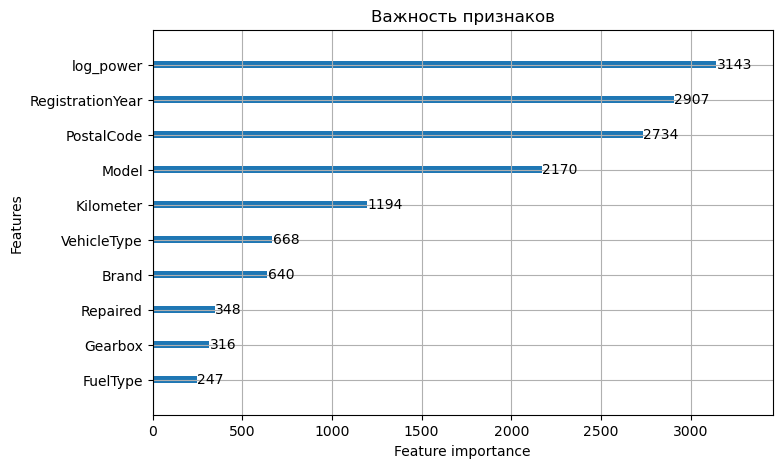

In [80]:
fig, ax = plt.subplots(figsize=(8, 5))
plot_importance(final_model, ax=ax, importance_type='split')
plt.title('Важность признаков')
plt.show()



Модель использовала индекс владельца авто, как основной признак для определения цены. Возможно это не является ошибочным, из практики известно, что в части регионов, например на севере, автомобили могут стоить дороже. Но требуется анализ и проработка имеющихся данных, возможно все-таки тут есть какая-то ошибка и как раз этот признак должен меньше всего влиять на стоимость авто. Есть предположение, что данные не соответсвуют действительности, необходимо все тщательно проверить с командой, собиравшей их. 

Далее определяющим цену автомобиля признаком является его модель, что уже больше соответсвует реальности, а также мощность двигателя. год регистрации и пробег.

Тип коробки передач, была машина в ремонте или нет, тип топлива оказывают меньшее влияние на предсказание цены.

# Общий вывод по проекту:

Были изучены данные для разработки приложения по определению цен на авто. В результате подобрана модель машинного обучения LGBM Regressor, которая максимально соответсвует требованиям заказачика, она достаточно надежна, среднеквадратичная ошибка менее 2500 и быстро обучается на новых данных. Модель сохранена и готова к использованию, предобработка для новых данных не требуется за исключением замены отсутвующих значений на "unknown", что очень удобно в пременении. 

Далее были проанализированы ошибки модели, выявлено, что модель занижает цену для довольно старых авто и завышает цену для автомобилей новее 2011 года. Цена завышается, если у автомобиля маленький пробег. Также модель плохо предсказывает цену на авто, чье количество в обучающей и тестовой выборке очень мало, например дорогие авто типа porshe или автомобили с электродвигателями. Модели недостаточно элементов для формирования закономерностей. 

Самой важной среди фичей оказался почтовый индекс владельца. Поэтому необходимо связаться с командой, предоставляющей данные и узнать, как собирался этот признак, нет ли в нем ошибки, посмотреть карту регионов с этими индексами. Действительно ли здесь есть какая-то закономерность.